**Gradient Boosting Classifier**

predicting the vendor_id values using Gradient Boosting Classifier


In [93]:
!pip install xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [94]:
import pandas as pd
import numpy as np

df_filtered = pd.read_csv("../ignore_files/df_filtered.csv")
df_filtered.dropna(inplace=True)
df_filtered.head()

,vendor_id,passenger_count,trip_duration,Distance_KM,Manhattan_Distance,store_and_fwd_flag_V,pickup_cluster,dropoff_cluster,day_of_week,is_weekend,pickup_hour,time_of_day_category,is_holiday,pickup_day,pickup_month
0,2,1,455,1.498521,0.019859,0,3,4,0,0,17,Evening_Rush,0,14,3
1,1,1,663,1.805507,0.026478,0,3,0,6,1,0,Night,0,12,6
2,2,1,2124,6.385098,0.080158,0,3,0,1,0,11,Midday,0,19,1
3,2,1,429,1.485498,0.015480,0,0,0,2,0,19,Evening_Rush,0,6,4
4,2,1,435,1.188588,0.010818,0,4,4,5,1,13,Midday,0,26,3


In [95]:
from sklearn.preprocessing import OrdinalEncoder
#The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are converted to ordinal integers.

store_fwd = OrdinalEncoder()
df_filtered['store_and_fwd_flag_V'] = store_fwd.fit_transform(df_filtered[['store_and_fwd_flag_V']])
df_filtered['time_of_day_category'] = store_fwd.fit_transform(df_filtered[['time_of_day_category']])


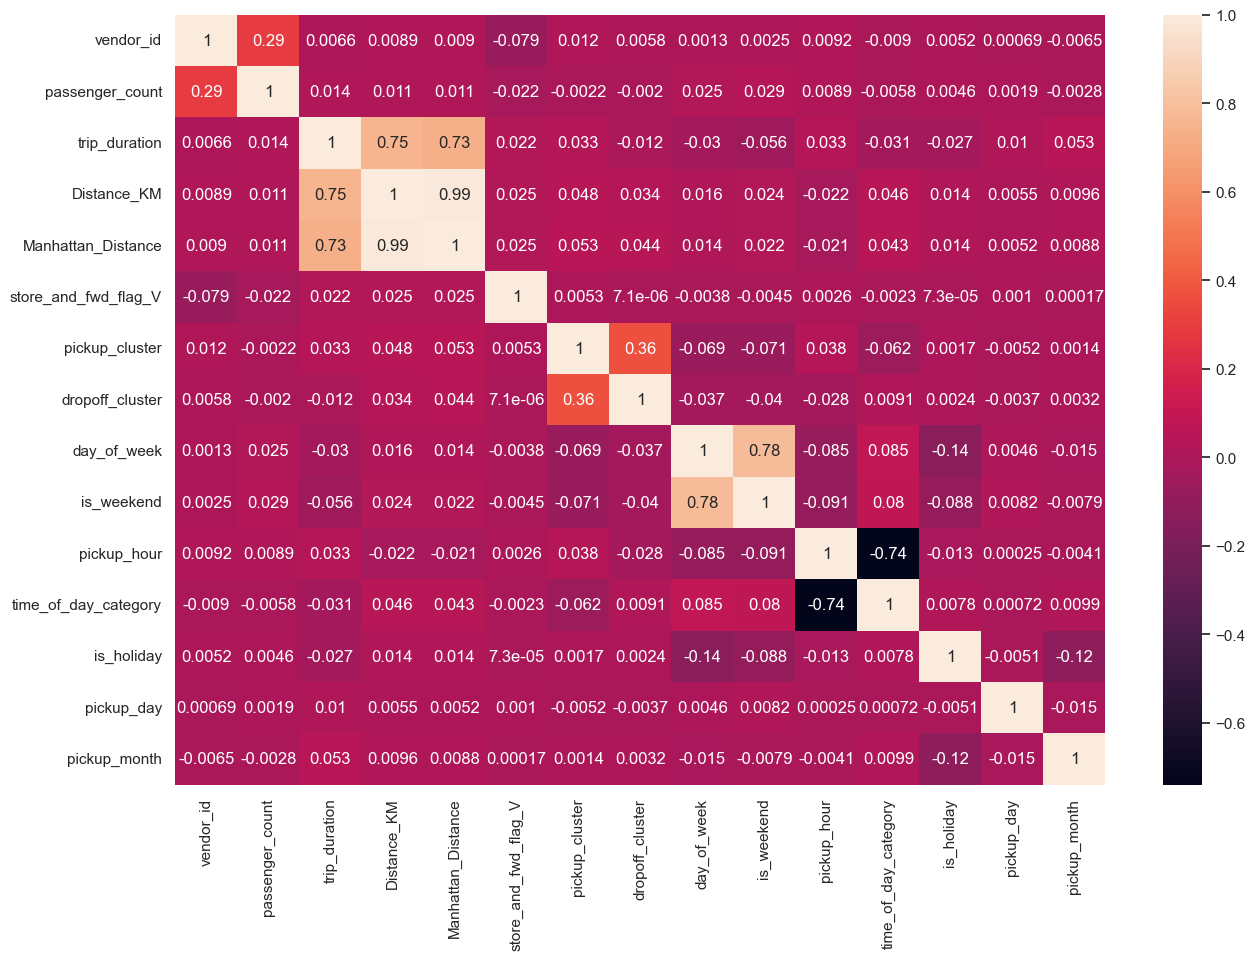

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15, 10)})

sns.heatmap(df_filtered.corr(), annot=True);

In [97]:
'''
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=(df_filtered.shape[1]//3)+1,
    cols=3,
    subplot_titles=df_filtered.columns
)

for i, col in enumerate(df_filtered.columns):
    fig.add_trace(go.Histogram(x=df_filtered[col], name=col), row=(i//3)+1, col=(i%3)+1)

fig.update_layout(height=800, showlegend=False)

fig.show()
'''

'\nimport plotly.graph_objects as go\nfrom plotly.subplots import make_subplots\n\nfig = make_subplots(\n    rows=(df_filtered.shape[1]//3)+1,\n    cols=3,\n    subplot_titles=df_filtered.columns\n)\n\nfor i, col in enumerate(df_filtered.columns):\n    fig.add_trace(go.Histogram(x=df_filtered[col], name=col), row=(i//3)+1, col=(i%3)+1)\n\nfig.update_layout(height=800, showlegend=False)\n\nfig.show()\n'

In [98]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, minmax_scale
from sklearn.compose import ColumnTransformer

# Define the target
# the model's target is 0 and 1 (integer)
df_filtered['vendor_id'] = df_filtered['vendor_id'].astype(int)

# Define categorical and numerical features
categorical_cols = ["store_and_fwd_flag_V","time_of_day_category", 'is_weekend','pickup_cluster', 'dropoff_cluster','is_holiday'] 

EXCLUDE_COL = categorical_cols
all_columns = df_filtered.columns
cols_to_scale = all_columns.drop(EXCLUDE_COL).tolist()
cols_retained = EXCLUDE_COL

# Separate the data
df_to_scale = df_filtered[cols_to_scale] # numerical columns that are going to be normalized
df_retained = df_filtered[cols_retained] # categorical columns

# Apply MinMax Scaling to the target columns ---
# We use minmax_scale which outputs a NumPy array. this makes the conversion faster
scaler_array = minmax_scale(df_to_scale, axis=0)

# Convert the scaled NumPy array back into a DataFrame
df_scaled = pd.DataFrame(scaler_array, columns=cols_to_scale)

# Recombine the scaled data with the retained column
# Concatenate the scaled columns (df_scaled) and the unscaled column (df_retained)
df_filtered_nor = pd.concat([df_scaled, df_retained], axis=1)


# 2. Feature Selection

In [99]:
X = df_filtered_nor.drop(['vendor_id'], axis=1)
y = df_filtered_nor['vendor_id']

In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 3. Algorithm

In [101]:
from xgboost import XGBClassifier

# Use n_jobs=-1 to use all CPU cores and speed up training
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)

model.fit(X_train, y_train)

c:\Progs\PySpark_Proj\spark_env\Lib\site-packages\xgboost\training.py:199: UserWarning:

[19:36:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


# 4. Predictions and **Evaluation metrics**

In [102]:
from sklearn.metrics import accuracy_score, f1_score, log_loss


## Confusion Matrix

A confusion matrix is a table that summarizes how well your classification model performs by comparing actual labels (y_test) to predicted labels (y_pred).

It shows counts of correct and incorrect predictions, broken down by each class.

In [103]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X)

cm = confusion_matrix(y, y_pred)

Confusion matrix, raw
[[101131  32980]
 [ 85775  67503]]
Confusion matrix, raw
[[0.7540843  0.2459157 ]
 [0.55960412 0.44039588]]


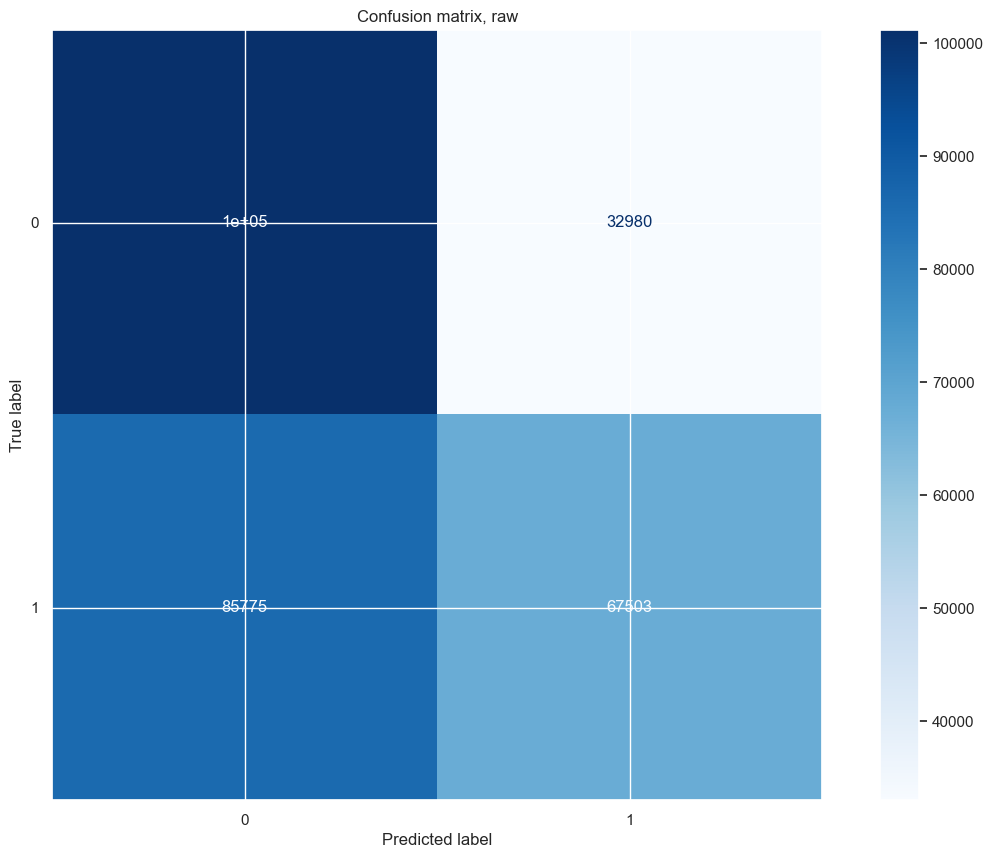

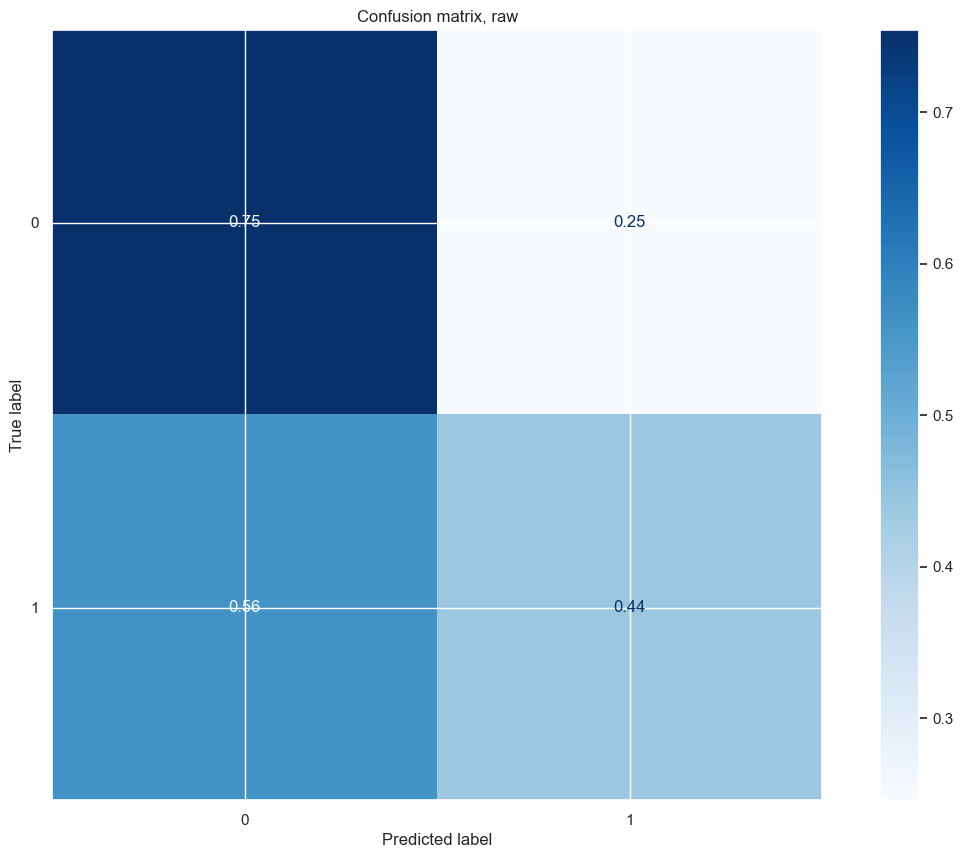

In [104]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
class_names = ['0', '1']

titles_options = [
    ("Confusion matrix, raw", None), #The raw counts of predictions
    ("Confusion matrix, raw", "true"), #The percentages of predictions
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Classification Report
1. **Precision** (The Quality of Positive Predictions)

Precision answers: "Out of all the trips the model said were Vendor X, how many actually were Vendor X?"


Formula: $\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$

Focus: It measures the accuracy of the positive predictions.

2. **Recall (The Completeness of Positive Predictions)**


Recall answers: "Out of all the trips that actually were Vendor X, how many did the model

Formula: $\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$

Focus: It measures the completeness of the result set.When it Matters: When the cost of a False Negative (failing to predict Vendor X when it was Vendor X) is high. For example, in anomaly detection, if you miss an actual fraudulent transaction (a False Negative), the cost could be enormous.

In [105]:
from sklearn.metrics import classification_report

y_pred = model.predict(X)

print(classification_report(y, y_pred, target_names=['0', '1'], zero_division=0))

              precision    recall  f1-score   support

           0       0.55      0.77      0.64    670011
           1       0.69      0.45      0.55    766933

    accuracy                           0.60   1436944
   macro avg       0.62      0.61      0.59   1436944
weighted avg       0.62      0.60      0.59   1436944



1. **Accuracy Score:**\
 Measures the percentage of correct predictions (both positive and negative).\
Accuracy=(TP+TN)/(TP+TN+FP+FN)\
2. **F1 Score**\
Combines precision and recall into a single metric using their harmonic mean. Imbalanced datasets, where accuracy can be misleading (e.g., predicting only the majority class).\
F1=2×(Precision+Recall)(Precision×Recall).
3. **Log Loss** (a.k.a. Cross-Entropy Loss) \
expects predicted probabilities, not binary class labels (0/1).Measures how confident your model’s probability predictions are.\


Summary Table
| Metric       | Input Type    | Range | Best Value | When to Use          |
| :----------- | :------------ | :---- | :--------- | :------------------- |
| **Accuracy** | Binary labels | 0–1   | 1.0        | Balanced data        |
| **F1 Score** | Binary labels | 0–1   | 1.0        | Imbalanced data      |
| **Log Loss** | Probabilities | 0–∞   | 0          | Probabilistic models |


In [106]:
#evaluation metrics
#scores for train data
y_pred = model.predict(X_train)

acc_train = accuracy_score(y_train, y_pred)
f1_train = f1_score(y_train, y_pred)
ll_train = log_loss(y_train, y_pred)

print(f"(train) accuracy_score: {acc_train}")
print(f"(train) f1_score: {f1_train}")
print(f"(train) log_loss: {ll_train}")

print(f"{'#'*40}")
#scores for test
y_pred = model.predict(X_test)

acc_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)
ll_test = log_loss(y_test, y_pred)

print(f"(test) accuracy_score: {acc_test}")
print(f"(test) f1_score: {f1_test}")
print(f"(test) log_loss: {ll_test}")

metrics = {
    "acc_train": acc_train,
    "f1_train": f1_train,
    "ll_train": ll_train,
    "acc_test": acc_test,
    "f1_test": f1_test,
    "ll_test": ll_test,
}
export_dict = {
    "model": model.__class__.__name__,
    "metrics": metrics,
}


(train) accuracy_score: 0.6022539156456194
(train) f1_score: 0.5498254855145592
(train) log_loss: 14.336222001347846
########################################
(test) accuracy_score: 0.5867795914248631
(test) f1_score: 0.532020286805301
(test) log_loss: 14.893973179991605


In [107]:
import os
CSV_FILE = "model_metrics.csv"
MODEL_KEY = 'model'
try:
    df_existing = pd.read_csv(CSV_FILE)
    print(f"Loaded existing data from '{CSV_FILE}' ({len(df_existing)} records).")
except (FileNotFoundError, pd.errors.EmptyDataError):
    df_existing = pd.DataFrame()

df_new_row = pd.json_normalize(export_dict)
# Check if the model name already exists in the existing DataFrame
model_name = df_new_row[MODEL_KEY].iloc[0]

if not df_existing.empty and model_name in df_existing[MODEL_KEY].values:
    print(f"Skipping: Model '{model_name}' already found in {CSV_FILE}.")
else:
    # If the model is new, combine the DataFrames
    print(f"Adding new model: '{model_name}'.")
    
    # Use pd.concat to merge, which automatically handles different columns (new metrics)
    df_combined = pd.concat([df_existing, df_new_row], ignore_index=True)
    
    # Export the combined DataFrame back to the CSV, overwriting the old file
    df_combined.to_csv(CSV_FILE, index=False)
    
    print(f"SUCCESS: Updated {CSV_FILE}. Total records: {len(df_combined)}.")    

Loaded existing data from 'model_metrics.csv' (6 records).
Skipping: Model 'XGBClassifier' already found in model_metrics.csv.


## A manual qualitative inspection of the model's predictions on a very small subset of the data.

In [108]:
small_sample = df_filtered_nor.sample(5).copy() #This randomly selects 5 rows from the normalized DataFrame

X_val = small_sample.drop(['vendor_id'], axis=1)
y_val = small_sample['vendor_id']

y_pred = y_pred = model.predict(X_val)
y_pred = pd.Series(y_pred, y_val.index)

for i in X_val.index:
    print(f'the index for this sample is: {i}')
    print(f"y_real = {y_val[i]}, y_pred = {y_pred[i]}, error = {y_val[i] - y_pred[i]}")
    
    print()

the index for this sample is: 800739
y_real = 1.0, y_pred = 1, error = 0.0

the index for this sample is: 1244663
y_real = 1.0, y_pred = 0, error = 1.0

the index for this sample is: 644063
y_real = 0.0, y_pred = 0, error = 0.0

the index for this sample is: 1066800
y_real = 1.0, y_pred = 0, error = 1.0

the index for this sample is: 477176
y_real = 1.0, y_pred = 1, error = 0.0



In [109]:
# 5. Visualizations
from plotly.subplots import make_subplots
import plotly.graph_objects as go


df_filtered_nor_sample = df_filtered_nor.sample(500) #This randomly selects 500 rows from the normalized DataFrame

X_val = df_filtered_nor_sample.drop(['vendor_id'], axis=1)
y_val = df_filtered_nor_sample['vendor_id']


def iscorrect(x):
    return "circle" if x else "x"


iscorrectv = np.vectorize(iscorrect)
fig = make_subplots(rows=1, cols=1)

y_pred = model.predict(X_val)

fig.add_trace(go.Contour( #decision boundary 
    x=X_val['passenger_count'],
    y=X_val['Distance_KM'],
    z=y_pred,
    showscale=False,
    opacity=0.40,
    colorscale='portland'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=X_val['passenger_count'],
    y=X_val['Distance_KM'],
    mode='markers',
    marker_symbol=iscorrectv(y_val == y_pred),
    text=y_val,
    marker=dict(
        color=y_val,
        colorscale='portland'
    )
), row=1, col=1)
#the model thinks Vendor 0 should be (e.g., blue) and where Vendor 1 should be (e.g., red).
#fig.update_layout(showlegend=False)

fig.show()

In [110]:

# 5. Visualizations
from plotly.subplots import make_subplots
df_filtered_nor_sample = df_filtered_nor.sample(500, random_state=42) # Use random_state for reproducibility

X_val = df_filtered_nor_sample.drop(['vendor_id'], axis=1)
y_val = df_filtered_nor_sample['vendor_id']


def iscorrect(x):
    # 'x' means incorrect prediction (error)
    # 'circle' means correct prediction
    return "circle" if x else "x" 

iscorrectv = np.vectorize(iscorrect)
fig = make_subplots(rows=1, cols=1, 
                    # Set the title of the plot clearly
                    subplot_titles=[f"Vendor Prediction Boundary (pickup_hour vs. Distance)"]
                   )

# 1. Generate Predictions for the Decision Boundary
y_pred = model.predict(X_val)

# --- TRACE 1: DECISION BOUNDARY (CONTOUR PLOT) ---
fig.add_trace(go.Contour(
    # New X-Axis: Time of Day
    x=X_val['pickup_hour'],
    # New Y-Axis: Trip Length
    y=X_val['Distance_KM'],
    z=y_pred,
    showscale=False,
    opacity=0.40,
    colorscale='portland',
    name='Model Prediction'
), row=1, col=1)

# --- TRACE 2: ACTUAL DATA POINTS (SCATTER PLOT) ---
fig.add_trace(go.Scatter(
    x=X_val['pickup_hour'],
    y=X_val['Distance_KM'],
    mode='markers',
    marker_symbol=iscorrectv(y_val == y_pred),
    text=[f"Actual Vendor: {int(v)}, Error: {int(e)}" for v, e in zip(y_val, y_val != y_pred)],
    marker=dict(
        color=y_val,
        colorscale='portland',
        size=8,
        line=dict(width=1, color='Black')
    ),
    name='Actual Data & Errors'
), row=1, col=1)

# Update layout for clarity
fig.update_layout(
    xaxis_title='Pickup Hour (Scaled)',
    yaxis_title='Distance (KM) (Scaled)',
    height=600,
    width=900,
    showlegend=True,
    template='plotly_white'
)

fig.show()
